In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np

#for portofolio optimization 
import scipy.optimize as sco


#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


In [2]:
days_to_lookback =  20    #int (input('days to search financial data:'))

In [3]:
riskfree = .0019

In [4]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [5]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-10-04 12-43-02'

In [6]:
path = os.getcwd() 
reportDir = os.path.join(path, "Markowitz portflio output " + timestamp)
reportDir

'/Users/reejungkim/Documents/Git/S&P/Markowitz portflio output 2020-10-04 12-43-02'

In [7]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [8]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [9]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [10]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [11]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

SP100_tickers.to_csv('S&P100 tickers.csv')

# Use DataReader to get financial data of S&P100 companies from yahoo

In [12]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        #symbol_data = pd.DataFrame()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

CPU times: user 6.83 s, sys: 834 ms, total: 7.66 s
Wall time: 2min 21s


In [13]:
df = df.loc[df['Date'].notnull()]

df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [14]:
df_Flat = df

# Prepare data frame to display volatility and to be normalized

In [15]:
d = df.pivot_table(values='Close', index='Date', columns='Symbol', aggfunc=np.sum, margins=False)

In [16]:
d.head()

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-14,115.360001,90.489998,105.690002,238.830002,485.910004,29.400000,94.949997,246.750000,253.899994,3102.969971,...,308.570007,198.839996,160.139999,37.869999,204.979996,60.320000,35.110001,24.809999,137.320007,36.660000
2020-09-15,115.540001,90.910004,106.580002,240.199997,497.670013,28.930000,94.839996,248.350006,263.750000,3156.129883,...,307.230011,202.369995,161.529999,37.320000,205.389999,60.599998,35.270000,24.879999,137.360001,36.270000
2020-09-16,112.129997,89.779999,105.699997,239.419998,476.000000,29.770000,95.910004,247.759995,263.290009,3078.100098,...,306.519989,201.419998,159.869995,38.160000,205.130005,60.369999,36.279999,25.709999,136.259995,37.810001
2020-09-17,110.339996,89.629997,106.660004,236.820007,474.299988,28.700001,92.800003,248.080002,250.729996,3008.729980,...,304.980011,201.649994,159.750000,37.889999,205.270004,60.590000,37.209999,25.110001,136.690002,37.799999
2020-09-18,106.839996,90.110001,106.860001,236.179993,467.549988,27.990000,91.279999,247.720001,245.500000,2954.909912,...,308.019989,199.800003,159.660004,37.619999,202.610001,60.349998,36.930000,25.129999,135.289993,37.189999


In [17]:
logChange = np.log(d / d.shift(1)) # geometric brownian motion. - make the errors being normally distributed.
# more standardly used than pct_change.  df_temp['Close'] in this case.
logChange.head()

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-15,0.001559,0.004631,0.008386,0.005720,0.023914,-0.016116,-0.001159,0.006463,0.038061,0.016987,...,-0.004352,0.017597,0.008642,-0.014630,0.001998,0.004631,0.004547,0.002817,0.000291,-0.010695
2020-09-16,-0.029958,-0.012508,-0.008291,-0.003253,-0.044519,0.028622,0.011219,-0.002379,-0.001746,-0.025034,...,-0.002314,-0.004705,-0.010330,0.022258,-0.001267,-0.003803,0.028234,0.032816,-0.008040,0.041583
2020-09-17,-0.016092,-0.001672,0.009041,-0.010919,-0.003578,-0.036604,-0.032964,0.001291,-0.048879,-0.022794,...,-0.005037,0.001141,-0.000751,-0.007101,0.000682,0.003638,0.025311,-0.023614,0.003151,-0.000265
2020-09-18,-0.032234,0.005341,0.001873,-0.002706,-0.014334,-0.025050,-0.016515,-0.001452,-0.021080,-0.018050,...,0.009918,-0.009217,-0.000564,-0.007151,-0.013043,-0.003969,-0.007553,0.000796,-0.010295,-0.016269


# pick tickers to use for portfolio
( highest growth rates)

In [18]:
tickers = pd.DataFrame((d.mean()/d.var()))
tickers.columns =['sharp']
tickers = tickers.sort_values(by='sharp', ascending=False).head(10)
symbols = tickers.index.tolist()
symbols

['PFE', 'PG', 'VZ', 'T', 'ORCL', 'CL', 'BMY', 'F', 'CMCSA', 'CVS']

tickers_bestPerformed = logChange.describe().transpose().sort_values(by='mean', ascending=False).head(5)
symbols = tickers_bestPerformed.index.tolist()

In [19]:
logChange = logChange[symbols]
logChange.head(3)

Symbol,PFE,PG,VZ,T,ORCL,CL,BMY,F,CMCSA,CVS
Date,,,,,,,,,,
2020-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-15,-0.001352,0.000000,0.004631,-0.000687,0.024586,-0.002726,-0.002852,-0.011300,0.025947,-0.016874
2020-09-16,-0.004882,-0.006731,-0.003803,0.004112,-0.008404,-0.000390,-0.001345,-0.002845,0.007505,0.008386


### expected return of each ticker picked

In [20]:
logChange.mean()*252   #252 business days per year in general

Symbol
PFE     -0.309040
PG      -0.066343
VZ      -0.325201
T       -0.286412
ORCL    -0.191733
CL       0.058234
BMY     -0.297929
F       -0.591060
CMCSA   -0.047777
CVS     -0.043523
dtype: float64

##### covariance across tickers

In [21]:
logChange.cov()*252

Symbol,PFE,PG,VZ,T,ORCL,CL,BMY,F,CMCSA,CVS
Symbol,,,,,,,,,,
PFE,0.018049,0.009485,0.008136,0.009512,-0.000744,0.012281,0.018262,0.021950,0.013332,0.013869
PG,0.009485,0.011767,0.008226,0.007375,0.010029,0.010278,0.009704,0.007122,0.019598,0.004586
VZ,0.008136,0.008226,0.009887,0.008859,0.009090,0.008782,0.007627,0.017191,0.014771,0.004311
T,0.009512,0.007375,0.008859,0.019151,0.007437,0.013220,-0.000211,0.027539,0.012855,0.009929
ORCL,-0.000744,0.010029,0.009090,0.007437,0.042138,0.004166,-0.005678,-0.022826,0.027249,-0.008750
CL,0.012281,0.010278,0.008782,0.013220,0.004166,0.016435,0.007316,0.019727,0.018316,0.002587
BMY,0.018262,0.009704,0.007627,-0.000211,-0.005678,0.007316,0.039381,0.001898,0.027106,0.011417
F,0.021950,0.007122,0.017191,0.027539,-0.022826,0.019727,0.001898,0.131536,-0.016199,0.033989
CMCSA,0.013332,0.019598,0.014771,0.012855,0.027249,0.018316,0.027106,-0.016199,0.084659,-0.014448


<AxesSubplot:xlabel='Symbol', ylabel='Symbol'>

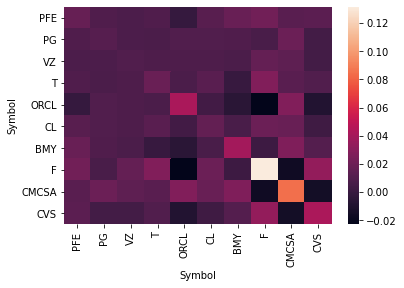

In [22]:
sns.heatmap(logChange.cov()*252)

# Portfolio with randomly assinged weights

#### get random portofolio weights to run simulations

In [23]:
np.random.seed(0)
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.08912692, 0.11614624, 0.09788834, 0.08848864, 0.06880123,
       0.10489274, 0.07106385, 0.14482329, 0.15649814, 0.06227063])

In [24]:
#expeced annual return of portfolio
np.sum(logChange.mean()*weights)*252

-0.21646834111224708

In [25]:
#expected annual variance of portfolio
np.dot(weights.T, np.dot(logChange.cov() * 252, weights))

0.014888741663566487

In [26]:
#expected annual standard deviation of portfolio (volatility)
np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))

0.12201943149993155

# Simulation of portfolios with random weights

In [27]:
prets = []  #stores list of portfolio returns
pvols = []  #stores list of portolfio volatilities

for p in range (5000):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(np.sum(logChange.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(logChange.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

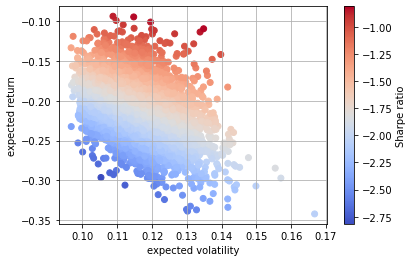

In [28]:

plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm') # mpl.cm.jet)

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') #beta
plt.show()

In [29]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
    
    Returns
    =======
    pret : float  (portfolio return)
    pvol : float   (portfoliio volatility)
    pret / pvol : float      #sharp ratio (beta)

    '''
    riskfree = .0019   #risk free rate .19% (1 Year Treasury Rate is at 0.19%)
    weights = np.array(weights)
    pret = np.sum(logChange.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))
    return np.array([pret, pvol, ((pret-riskfree )/ pvol)])

### Sharp ratio optimization

In [30]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [31]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
cons

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [32]:
#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
statistics(w)

array([-0.21007834,  0.11118071, -1.9066107 ])

In [33]:
bnds = tuple((0, 1) for x in range(len(symbols)))
bnds

((0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1))

In [74]:
#set initial point
len(symbols)* [1./len(symbols),]

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

#### Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP).

#### scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

In [73]:
%%time

opts = sco.minimize(min_func_sharpe, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)


CPU times: user 71.5 ms, sys: 3.19 ms, total: 74.7 ms
Wall time: 73.7 ms


In [36]:
opts

     fun: -0.4394279071508613
     jac: array([ 2.73902548,  0.79231751,  2.77153464,  2.58762125,  1.60699385,
       -0.01482087,  2.51958714,  5.13799665,  0.86242155,  0.40865864])
 message: 'Optimization terminated successfully.'
    nfev: 48
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.11287613e-15, 0.00000000e+00, 9.97149850e-16, 7.15202457e-16,
       0.00000000e+00, 1.00000000e+00, 6.73782911e-16, 8.18849182e-15,
       3.59157148e-14, 0.00000000e+00])

In [37]:
a=opts['x'].round(3)   #opt weights
#print("exp return :" + str( np.sum(logChange.mean()*a)*252  )  ).round(3)   #1yr exp return of portfolio with opt weights 
print("exp return :" + str( statistics(opts['x'].round(3))[0].round(3) ) )
print("exp volatility :" + str( statistics(opts['x'].round(3))[1].round(3) )  )
print("exp sharp ratio :" + str( statistics(opts['x'].round(3))[2].round(3) )  )

exp return :0.058
exp volatility :0.128
exp sharp ratio :0.439


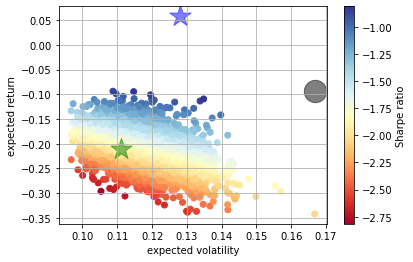

In [38]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
plt.scatter(statistics(w)[1], statistics(w)[0], marker="*", s= 500, alpha=0.5, color='g')


# add a red dot for maximum vol & maximum return
plt.scatter(pvols.max(), prets.max(), c='black', s=500, alpha=0.5, edgecolors='black')



plt.show()

### Volatility Optimization

In [39]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [40]:
optv = sco.minimize(min_func_variance,  len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [41]:
optv

     fun: 0.008594742976769197
     jac: array([0.01857526, 0.01749948, 0.0169985 , 0.01779065, 0.01719308,
       0.01730996, 0.01683471, 0.02786344, 0.02689027, 0.01740664])
 message: 'Optimization terminated successfully.'
    nfev: 240
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.23427739e-18, 1.50458555e-01, 4.25445003e-01, 1.49344627e-17,
       9.84069935e-02, 1.39345339e-01, 4.02009745e-02, 0.00000000e+00,
       1.52971140e-17, 1.46143134e-01])

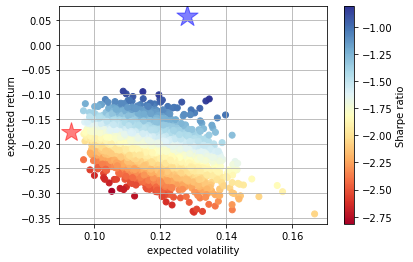

In [42]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
           
    
plt.show()

# Efficient Frontier

## Minimum variance frontier

In [43]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [44]:
def min_func_port(weights):
    return statistics(weights)[1]

In [45]:
prets.min(), prets.max(), pt_opts[0]

(-0.34219424513576685, -0.09374764942017084, 0.058)

In [46]:
%%time


trets = np.linspace( prets.min() , max(prets.max(), pt_opts[0].max()), 50)
tvols = []
for tret in trets:       #getting weight where minimum volatility occurs for each returned value
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 12.5 s, sys: 47.1 ms, total: 12.6 s
Wall time: 12.6 s


In [47]:
tvols

array([0.10571401, 0.10200861, 0.09896964, 0.0972823 , 0.09625879,
       0.09542055, 0.09477193, 0.09431721, 0.09400592, 0.09373983,
       0.09351813, 0.09334299, 0.09318217, 0.0930412 , 0.09291434,
       0.09280352, 0.09271628, 0.09265735, 0.09262746, 0.09262693,
       0.09265472, 0.09271183, 0.09279804, 0.09291304, 0.09305661,
       0.09322903, 0.09342967, 0.09365834, 0.09391549, 0.09420026,
       0.09451233, 0.094852  , 0.09521867, 0.09561215, 0.09603207,
       0.09647882, 0.09694912, 0.09746199, 0.09810994, 0.09890418,
       0.09987354, 0.10113385, 0.10268464, 0.1045191 , 0.10672411,
       0.10931573, 0.1122677 , 0.11555145, 0.12047811, 0.12795052])

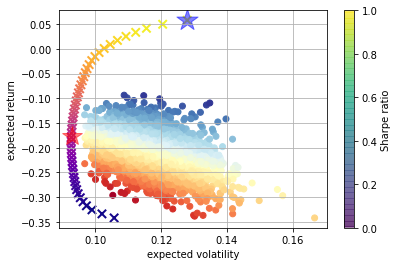

In [48]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
    
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')

 
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Efficient frontier

In [49]:
import scipy.interpolate as sci

In [50]:
np.argmin(tvols) #find index of minimum value of volatility 


19

In [51]:
ind = np.argmin(tvols)
evols = tvols[ind:]    #include array only up to the index of minimum volatility
erets = trets[ind:]


In [52]:
tck = sci.splrep(evols, erets)

In [53]:
def f(x):
    ''' efficient frontier (spline) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' efficient frontier (first derivative)'''
    return sci.splev(x, tck, der=1)
f(0)

array(-9795874.04916258)

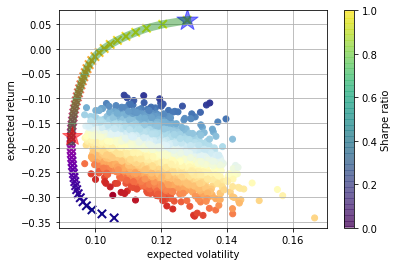

In [54]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Efficient frontier
plt.plot(evols, f(evols), lw=8, alpha=0.4, color='green')  

# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
 

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Capital market line (CML)

In [55]:
riskfree

0.0019

In [56]:
def equations(p, rf=riskfree):
    eq1 = rf-p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [57]:
pvols.max()/2, prets.max()/2


(0.08335532593349594, -0.04687382471008542)

In [58]:
opt = sco.fsolve(equations,[ riskfree, pvols.max()/2, prets.max()/2])
opt

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.0019    , 1.01433907, 0.12440319])

In [59]:
np.round(equations(opt), 8)

array([ 0.        ,  0.07393853, -0.00919818])

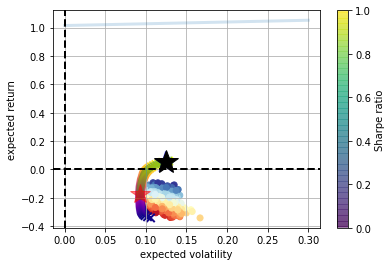

In [81]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Efficient frontier
plt.plot(evols, f(evols), lw=8, alpha=0.4, color='green')  

# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
 


 
#Capital market line
cx = np.linspace(0.0, 0.3 )   # (0.0, 0.3)
plt.plot(cx, opt[1] + opt[2] * cx, lw=3, alpha=0.2, ) 
    
    
#optimal portfolio  
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0, color='black') 


plt.grid(True)
plt.axhline(0.0, color='k', ls='--', lw=2.0)
plt.axvline(0.0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

#### Optimal portfolio weights

In [61]:
symbols

['PFE', 'PG', 'VZ', 'T', 'ORCL', 'CL', 'BMY', 'F', 'CMCSA', 'CVS']

In [62]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.96, 0.  , 0.  , 0.  , 0.04])

In [63]:
statistics(res['x'].round(3))

array([0.05416336, 0.12414877, 0.42097365])

#### return, volatility, and sharp ratio expected with the optimal weights

In [64]:
portfolio = list(zip(symbols, res['x'].round(3)))
portfolio

[('PFE', 0.0),
 ('PG', 0.0),
 ('VZ', 0.0),
 ('T', 0.0),
 ('ORCL', 0.0),
 ('CL', 0.96),
 ('BMY', 0.0),
 ('F', 0.0),
 ('CMCSA', 0.0),
 ('CVS', 0.04)]

In [65]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [66]:
summary_output = pd.DataFrame({'Symbol': symbols})
summary_output['Weight'] = res['x'].round(3)

summary_output = pd.merge(summary_output , (logChange.mean()*252).reset_index(name='temp'))

summary_output['Exp return'] = summary_output['Weight']*summary_output['temp']

summary_output = summary_output.pivot_table(index='Symbol', values=['Weight', 'Exp return']  , aggfunc=np.sum, margins=True)


format_column_percentage(summary_output, ['Exp return', 'Weight'])
summary_output

,Exp return,Weight
Symbol,,
BMY,0.00%,0.00%
CL,5.59%,96.00%
CMCSA,0.00%,0.00%
CVS,-0.17%,4.00%
F,0.00%,0.00%
ORCL,0.00%,0.00%
PFE,0.00%,0.00%
PG,0.00%,0.00%
T,0.00%,0.00%


In [67]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [68]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [69]:
story = []

In [70]:
story.append(Paragraph("Portfolio", getSampleStyleSheet()['Heading1']))
story.append(PrepareTableForReportLab(summary_output))

story.append(PageBreak())

In [71]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [72]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)

CompletedProcess(args=['open', 'Report 2020-10-04.pdf'], returncode=0)